In [110]:
import polars as pl
import matplotlib.pyplot as plt

from common.constants.column_types import CPZP_SCHEMA, OZP_SCHEMA
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)

FILE_PATH = "./DATACON_data/CPZP_preskladane.csv"


def read_preskladane_data(file_path: str, schema: pl.Schema) -> pl.DataFrame:
    return pl.read_csv(
        file_path,
        null_values=["NA", ""],
        schema=schema,
    )


ozp_df = read_preskladane_data(FILE_PATH, CPZP_SCHEMA)

print("OZP DATA: ", ozp_df.schema)

# print(ozp_df.filter(pl.col("Id_pojistence") == 485932.0))

OZP DATA:  Schema({'Id_pojistence': Float64, 'Pohlavi': Enum(categories=['M', 'Z']), 'Rok_narozeni': Int64, 'Mesic_narozeni': Int64, 'Posledni_zahajeni_pojisteni': Date, 'Posledni_ukonceni_pojisteni': Date, 'Rok_umrti': Int64, 'Mesic_umrti': Int64, 'Typ_udalosti': Enum(categories=['předpis', 'vakcinace']), 'Kod_udalosti': String, 'Detail_udalosti': String, 'Pocet_baleni': Float64, 'Datum_udalosti': Date, 'Specializace': String, 'Datum_umrti': Date, 'léková_forma_zkr': String, 'ATC_skupina': String, 'síla': String, 'doplněk_názvu': String, 'léková_forma': String, 'léčivé_látky': String, 'Equiv_sloucenina': Enum(categories=['TRIAMCINOLON', 'FLUDROKORTISON', 'METHYLPREDNISOLON', 'DEXAMETHASON', 'PREDNISON', 'BETAMETHASON', 'HYDROKORTISON']), 'Prednison_equiv': Float64, 'Pocet_v_baleni': Float64, 'pololeti': Int64, 'rok_zahajeni': Int64, 'poradi': Int64, 'pocet_vakcinaci': Int64, 'ockovany': Enum(categories=['1', '0']), 'pocet_predpisu': Int64})


In [2]:
def get_vekova_kohorta(vek):
    if vek >= 80:
        return "80+"
    elif vek >= 70:
        return "70-79"
    elif vek >= 65:
        return "65-69"
    elif vek >= 60:
        return "60-64"
    elif vek >= 50:
        return "50-59"
    elif vek >= 30:
        return "30-49"
    elif vek >= 12:
        return "12-29"
    else:
        return "<12"

In [112]:
# Filter only vaccinated and deceased
vax_and_deceased = ozp_df.filter(
    (pl.col(SHARED_COLUMNS.DATUM_UMRTI).is_not_null())
    & (pl.col(SHARED_COLUMNS.TYP_UDALOSTI) == "vakcinace")
)

# Create a dose number (1, 2, 3...) for each person
vax_with_dose_number = vax_and_deceased.sort(
    ["Id_pojistence", SHARED_COLUMNS.DATUM_UDALOSTI]
).with_columns(
    (pl.arange(0, pl.count()).over("Id_pojistence") + 1).alias("Cislo_davky")
)
# Get death/birth info (unique per person)
death_info = vax_with_dose_number.select(
    [
        "Id_pojistence",
        pl.col(SHARED_COLUMNS.DATUM_UMRTI).alias("Datum_umrti"),
        pl.col(SHARED_COLUMNS.ROK_NAROZENI).alias("Rok_narozeni"),
    ]
).unique(subset=["Id_pojistence"])

# Join and compute days from vax to death
all_vax_and_death_delays = (
    vax_with_dose_number.join(death_info, on="Id_pojistence", how="left")
    .with_columns(
        [
            (pl.col("Datum_umrti") - pl.col(SHARED_COLUMNS.DATUM_UDALOSTI))
            .dt.total_days()
            .alias("days_from_vax_to_death"),
            (pl.col("Datum_umrti").dt.year() - pl.col("Rok_narozeni")).alias(
                "Vek_v_dobe_umrti"
            ),
        ]
    )
    .with_columns(
        pl.col("Vek_v_dobe_umrti")
        .map_elements(get_vekova_kohorta, return_dtype=pl.Utf8)
        .alias("Vekova_kohorta")
    )
    .select(
        [
            "Id_pojistence",
            "Cislo_davky",
            SHARED_COLUMNS.DATUM_UDALOSTI,
            "Datum_umrti",
            "days_from_vax_to_death",
            "Vek_v_dobe_umrti",
            "Vekova_kohorta",
        ]
    )
    .sort(["Id_pojistence", "Cislo_davky"])
)

# print(all_vax_and_death_delays)

/tmp/ipykernel_52247/2477475264.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  (pl.arange(0, pl.count()).over("Id_pojistence") + 1).alias("Cislo_davky")


In [113]:
last_vax_and_death_delay = (
    ozp_df.filter(
        (pl.col(SHARED_COLUMNS.DATUM_UMRTI).is_not_null())
        & (pl.col(SHARED_COLUMNS.TYP_UDALOSTI) == "vakcinace")
    )
    .group_by("Id_pojistence")
    .agg(
        [
            pl.col(SHARED_COLUMNS.DATUM_UDALOSTI).max().alias("last_vax_date"),
            pl.col(SHARED_COLUMNS.DATUM_UMRTI)
            .max()
            .alias("Datum_umrti"),  # datum úmrtí by mělo být stejný v rámci ID
            pl.col(SHARED_COLUMNS.ROK_NAROZENI)
            .max()
            .alias("Rok_narozeni"),  # datum narozeni by mělo být stejný v rámci ID
            pl.col("pocet_vakcinaci").max().alias("Cislo_davky"),
        ]
    )
    .with_columns(
        [
            (pl.col("Datum_umrti") - pl.col("last_vax_date"))
            .dt.total_days()
            .alias("days_from_vax_to_death"),
            (pl.col("Datum_umrti").dt.year() - pl.col("Rok_narozeni")).alias(
                "Vek_v_dobe_umrti"
            ),
        ]
    )
    .with_columns(
        pl.col("Vek_v_dobe_umrti")
        .map_elements(get_vekova_kohorta, return_dtype=pl.Utf8)
        .alias("Vekova_kohorta")
    )
    .select(
        [
            "Id_pojistence",
            "Vekova_kohorta",  # věková skupina úmrtí
            "days_from_vax_to_death",  # počet dní od poslední vakcinační doby do úmrtí
            "Cislo_davky",  # počet dávek vakcinační
        ]
    )
)


death_groups = (
    last_vax_and_death_delay.with_columns(
        [
            pl.when(pl.col("days_from_vax_to_death") <= 28)
            .then(pl.lit("<= 28 dní"))
            .otherwise(pl.lit("> 28 dní"))
            .alias("vax_to_death_window")
        ]
    )
    .group_by(["Cislo_davky", "Vekova_kohorta", "vax_to_death_window"])
    .len()
    .rename({"len": "death_count"})
    .sort(["Vekova_kohorta", "Cislo_davky", "vax_to_death_window"])
)


death_counts_with_age_cohorts = (
    last_vax_and_death_delay.group_by(
        ["Vekova_kohorta", "Cislo_davky", "days_from_vax_to_death"]
    )
    .len()
    .rename({"len": "death_count"})
    .sort(["Vekova_kohorta", "Cislo_davky", "days_from_vax_to_death"])
)


death_counts_without_age_cohorts = (
    last_vax_and_death_delay.group_by(["Cislo_davky", "days_from_vax_to_death"])
    .len()
    .rename({"len": "death_count"})
    .sort(["Cislo_davky", "days_from_vax_to_death"])
)
# print(last_vax_and_death_delay.filter(pl.col("days_from_vax_to_death") < 0))

# print(f"last_vax_and_death_delay: {last_vax_and_death_delay}")
# print(f"death_groups: {death_groups}")
# print(f"death_counts_with_age_cohorts: {death_counts_with_age_cohorts}")
# print(f"death_counts_without_age_cohorts: {death_counts_without_age_cohorts}")

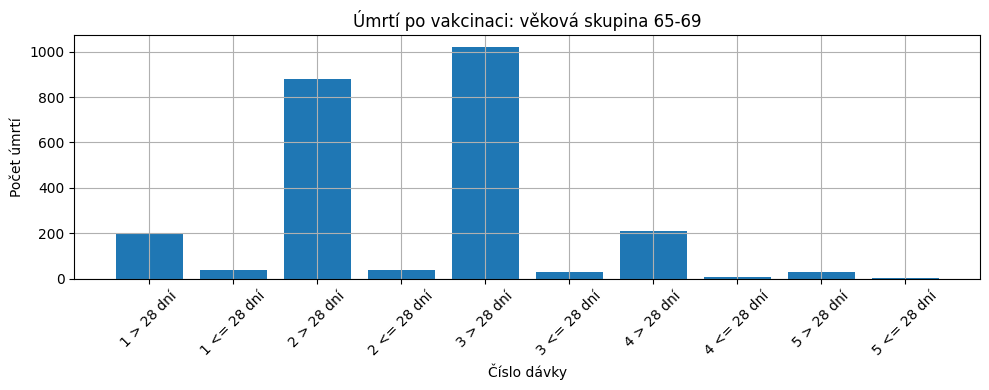

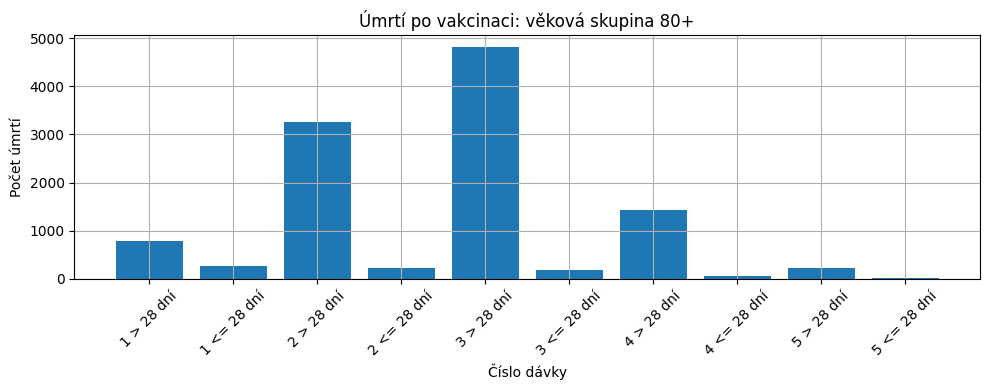

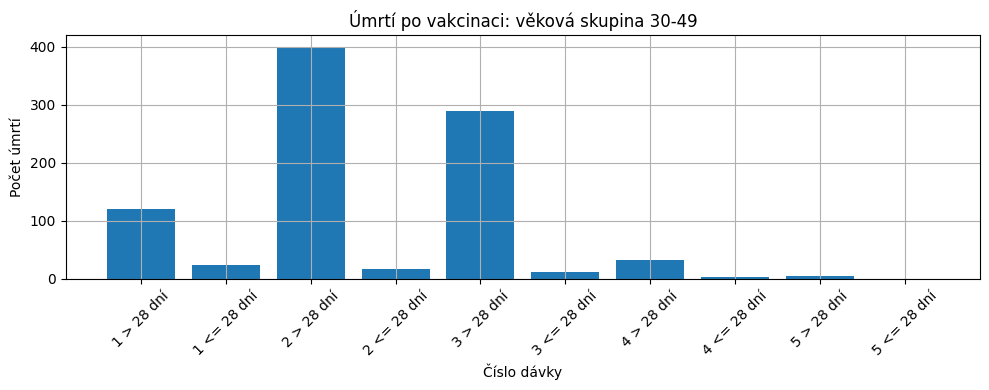

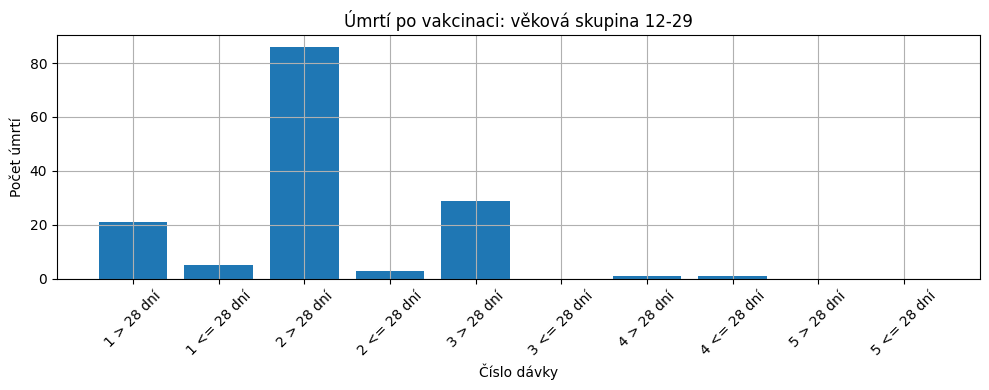

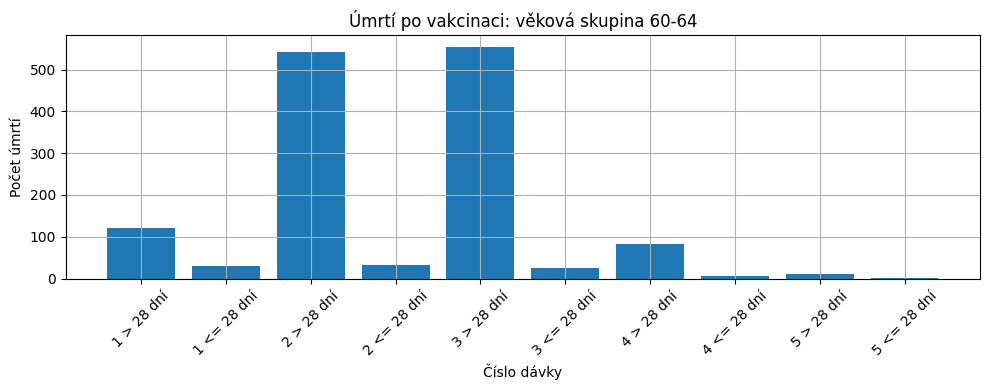

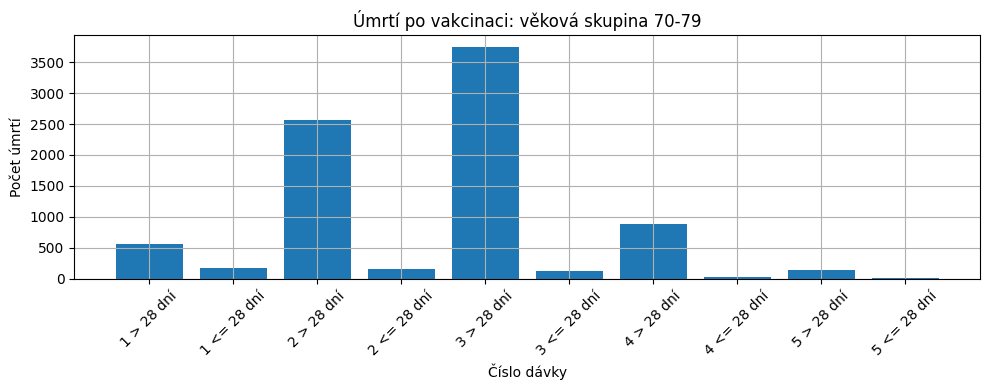

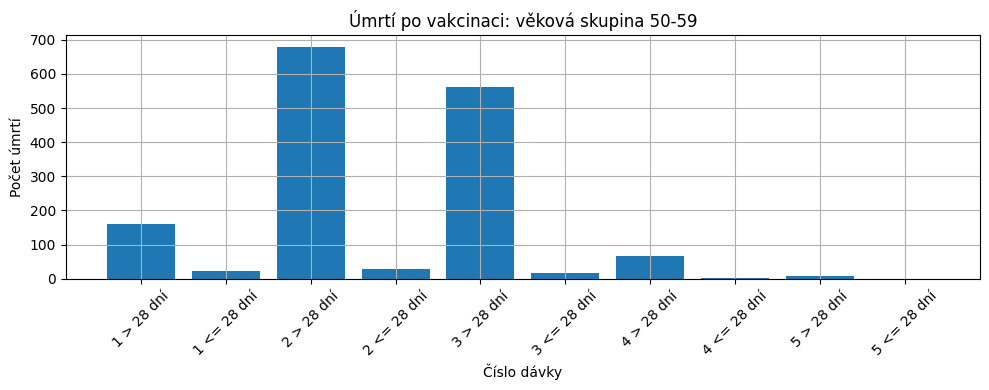

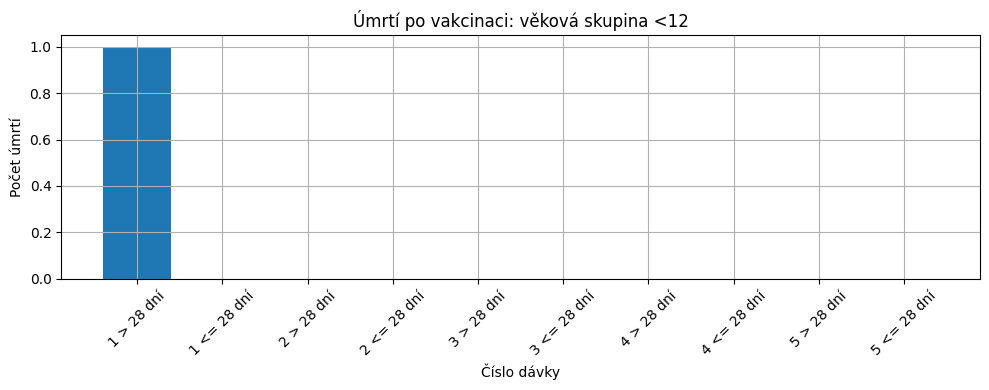

In [4]:
for vek_kohorta in death_groups["Vekova_kohorta"].unique():
    death_groups_vek = death_groups.filter(pl.col("Vekova_kohorta") == vek_kohorta)
    bar_heights = []
    bar_labels = []
    for cislo_davky in [1, 2, 3, 4, 5]:
        death_groups_vek_cislo_davky = death_groups_vek.filter(
            pl.col("Cislo_davky") == cislo_davky
        )
        for window in ["> 28 dní", "<= 28 dní"]:
            death_groups_vek_cislo_davky_window = death_groups_vek_cislo_davky.filter(
                pl.col("vax_to_death_window") == window
            )
            bar_heights.append(death_groups_vek_cislo_davky_window["death_count"].sum())
            bar_labels.append(f"{cislo_davky} {window}")

    plt.figure(figsize=(10, 4))
    plt.bar(bar_labels, bar_heights)
    plt.title(f"Úmrtí po vakcinaci: věková skupina {vek_kohorta}")
    plt.xlabel("Číslo dávky")
    plt.ylabel("Počet úmrtí")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

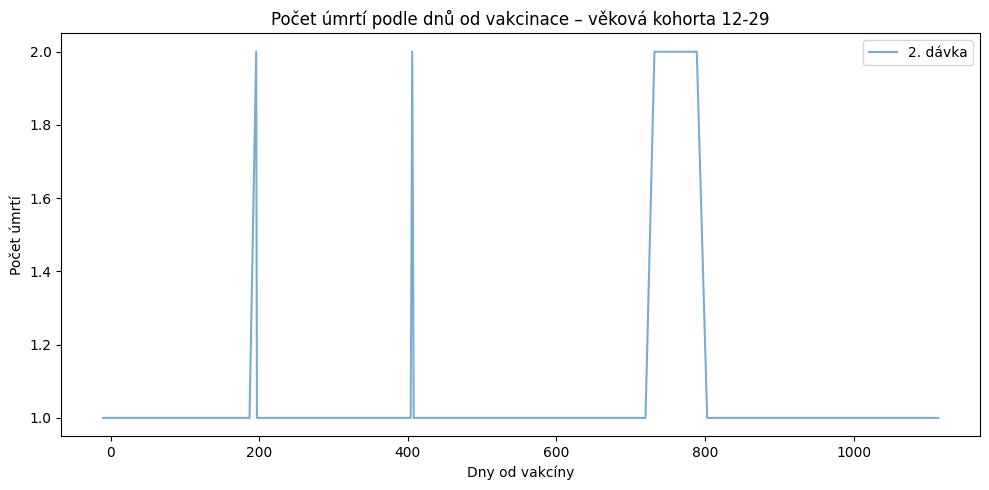

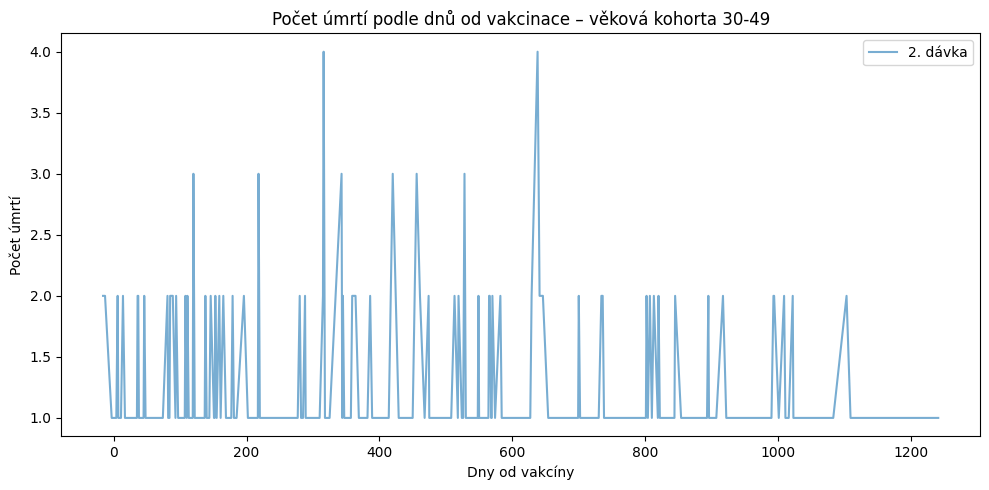

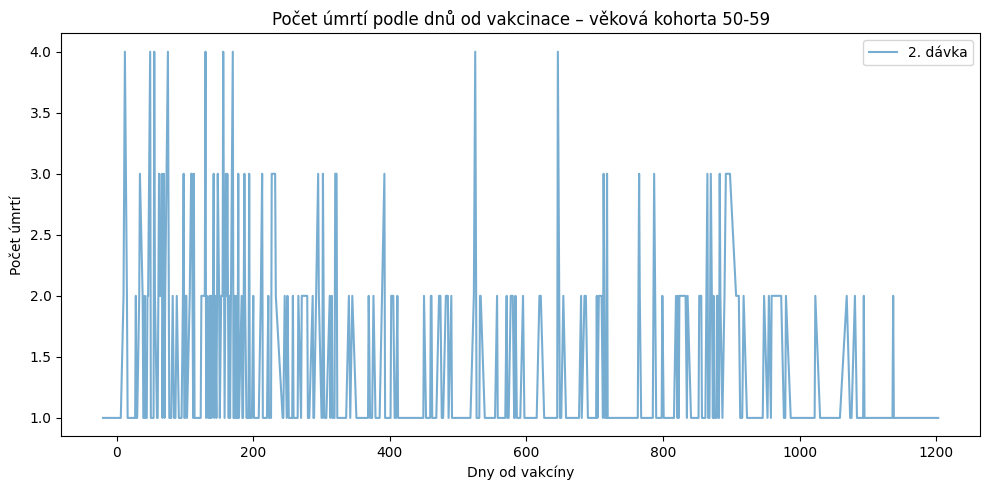

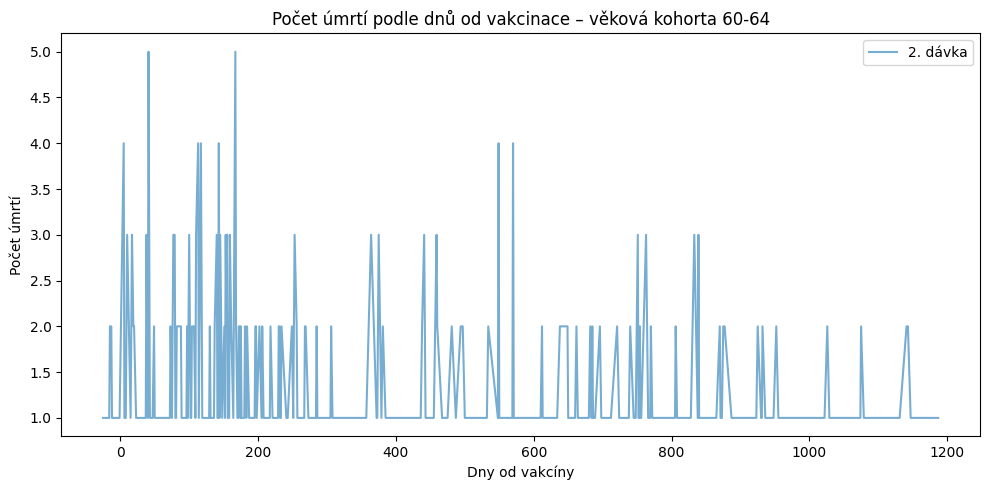

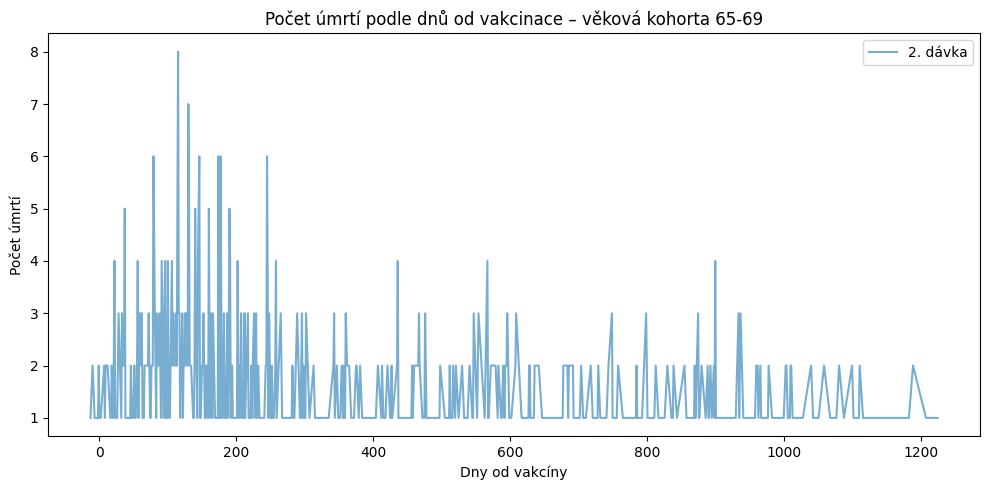

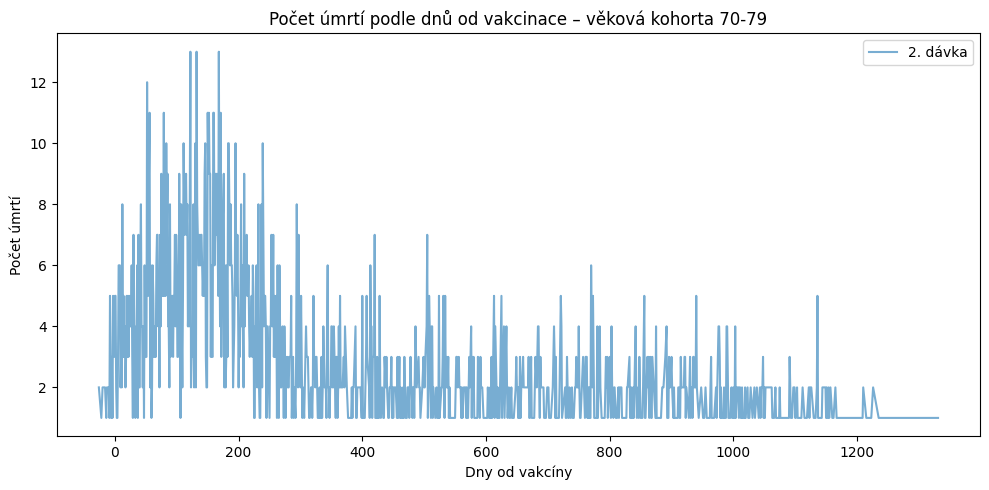

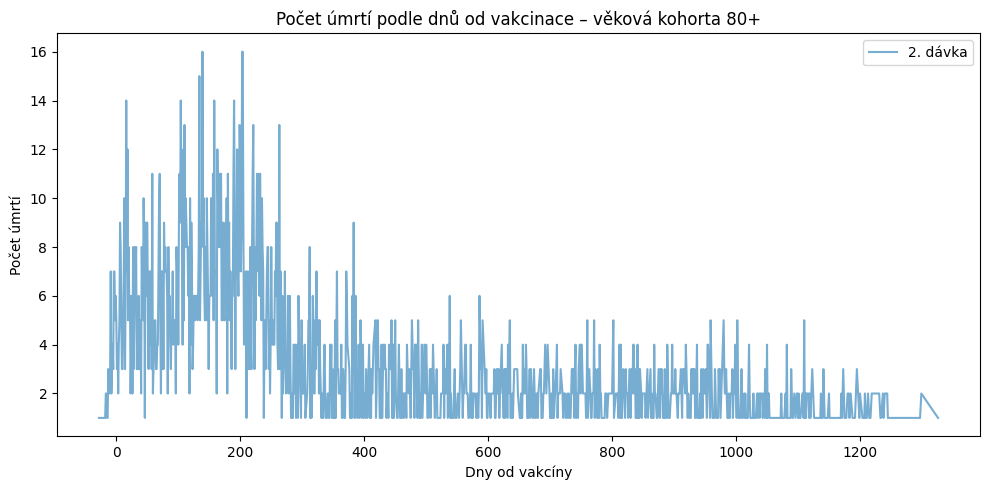

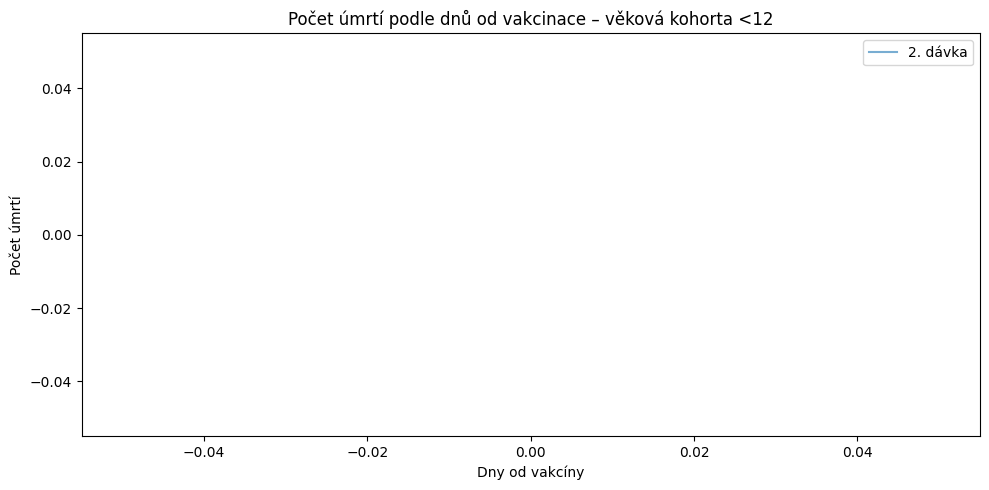

In [5]:
cohorts = (
    death_counts_with_age_cohorts.select("Vekova_kohorta")
    .unique()
    .to_series()
    .to_list()
)
for cohort in cohorts:
    cohort_df = death_counts_with_age_cohorts.filter(pl.col("Vekova_kohorta") == cohort)

    dose_counts = cohort_df.select("Cislo_davky").unique().to_series().to_list()

    plt.figure(figsize=(10, 5))

    dose = 2
    dose_df = (
        cohort_df.filter(pl.col("Cislo_davky") == dose)
        .select(["days_from_vax_to_death", "death_count"])
        .sort("days_from_vax_to_death")
    )

    data = dose_df.to_dicts()
    x = [row["days_from_vax_to_death"] for row in data]
    y = [row["death_count"] for row in data]

    # plt.plot(x, y, label=f"{dose}. dávka", alpha=0.6, marker="o", linestyle="")
    plt.plot(x, y, label=f"{dose}. dávka", alpha=0.6, linestyle="-")

    plt.title(f"Počet úmrtí podle dnů od vakcinace – věková kohorta {cohort}")
    plt.xlabel("Dny od vakcíny")
    plt.ylabel("Počet úmrtí")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()  # doporučené při batch generování grafů

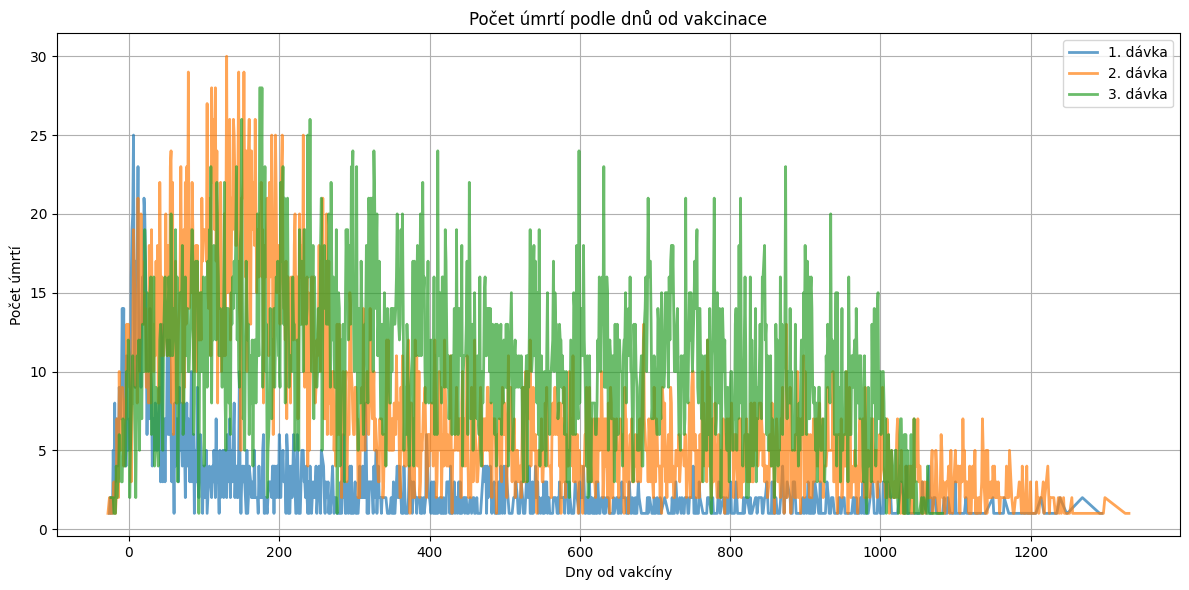

In [114]:
# print(death_counts_without_age_cohorts)

plt.figure(figsize=(12, 6))
# for dose in [3]:
for dose in [1, 2, 3]:
    dose_df = (
        death_counts_without_age_cohorts.filter(
            (pl.col("Cislo_davky") == dose) & (pl.col("days_from_vax_to_death") <= 3000)
        )
        .select(["days_from_vax_to_death", "death_count"])
        .sort("days_from_vax_to_death")
    )
    data = dose_df.to_dicts()
    x = [row["days_from_vax_to_death"] for row in data]
    y = [row["death_count"] for row in data]
    plt.plot(x, y, label=f"{dose}. dávka", alpha=0.7, linewidth=2)


plt.title("Počet úmrtí podle dnů od vakcinace")
# plt.xlim(-200, 1400)
plt.xlabel("Dny od vakcíny")
plt.ylabel("Počet úmrtí")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
BIN_SIZE = 10
binned_death_counts = (
    last_vax_and_death_delay.with_columns(
        (pl.col("days_from_vax_to_death") // BIN_SIZE * BIN_SIZE).alias("days_bin")
    )
    .group_by(["Cislo_davky", "days_bin"])
    .len()
    .rename({"len": "death_count"})
    .sort(["Cislo_davky", "days_bin"])
)


dose_counts = binned_death_counts.select("Cislo_davky").unique().to_series().to_list()

plt.figure(figsize=(10, 5))

# for dose in sorted(dose_counts):
dose = 3
dose_df = (
    binned_death_counts.filter(pl.col("Cislo_davky") == dose)
    .select(["days_bin", "death_count"])
    .sort("days_bin")
)

data = dose_df.to_dicts()
x = [row["days_bin"] for row in data]
y = [row["death_count"] for row in data]

plt.bar(x, y, width=BIN_SIZE, align="edge", alpha=0.6, label=f"{dose}. dávka")

plt.title("Počet úmrtí podle dnů od vakcinace")
plt.xlabel(f"Dny od vakcíny (bin po {BIN_SIZE} dnech)")
plt.ylabel("Počet úmrtí")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(f"./out/CPZP/hve/hve_dose_{dose}.png")
plt.close()

HVE u 1. dávky je nejsilnější, protože vyřazuje akutně nemocné (nemůžou přijít na očkování). U 2. dávky ten výběr už proběhl, takže propad v úmrtnosti nemusí nastat hned, ale až ve chvíli, kdy se znovu objeví vlivněné faktory (epidemie, sezóna).


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_baseline, logit_p, HVE_WINDOW_IN_DAYS, s]


/home/rogr/Projects/DATACON/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
lambda_baseline     2.150  0.066   2.034    2.285      0.001    0.001   
hve_probability     0.213  0.210   0.002    0.658      0.004    0.004   
HVE_WINDOW_IN_DAYS  3.571  4.517   0.000   10.888      0.076    0.146   
s                   2.156  2.023   0.001    5.936      0.031    0.033   

                    ess_bulk  ess_tail  r_hat  
lambda_baseline       4603.0    4702.0    1.0  
hve_probability       3213.0    3501.0    1.0  
HVE_WINDOW_IN_DAYS    2565.0    2604.0    1.0  
s                     2189.0    1267.0    1.0  


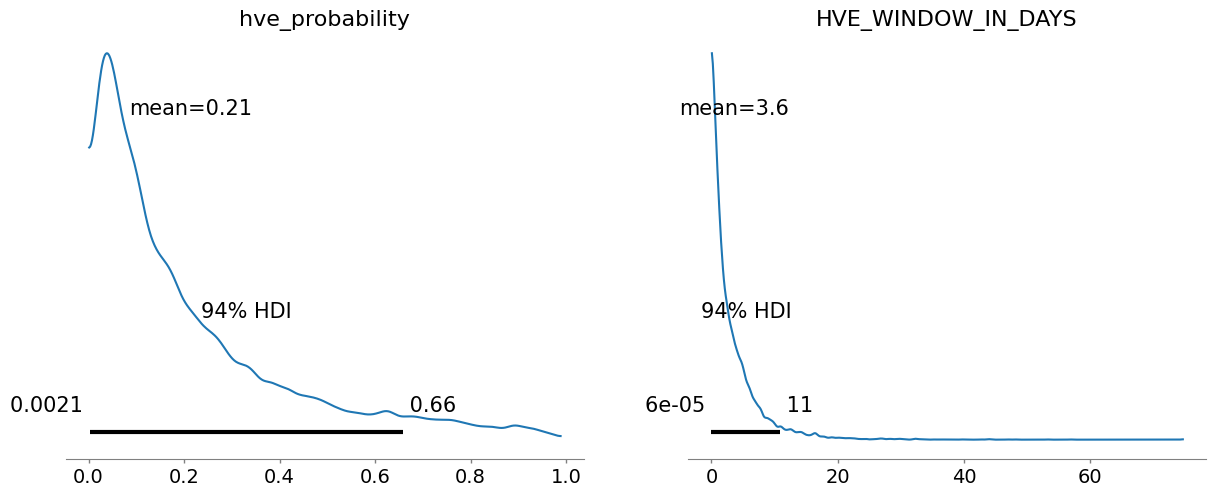

In [64]:
import polars as pl
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# --- 1) Data ---
dose_num = 1  # <--- vyber dávku (1, 2 nebo 3)

df = death_counts_without_age_cohorts.filter(pl.col("Cislo_davky") == dose_num)
days = df["days_from_vax_to_death"].to_numpy()
deaths = df["death_count"].to_numpy()

# --- 2) Model ---
with pm.Model() as model:
    lambda_baseline = pm.HalfNormal("lambda_baseline", sigma=10.0)

    logit_p = pm.Normal("logit_p", 0.0, 1.5)
    p = pm.Deterministic("hve_probability", pm.math.sigmoid(logit_p))

    w = pm.HalfNormal("HVE_WINDOW_IN_DAYS", sigma=21.0)  # typicky do ~30 dnů
    s = pm.HalfNormal("s", sigma=5.0)

    sig = pm.math.sigmoid((w - days) / s)
    mu = lambda_baseline * (1 - p * sig)

    pm.Poisson("y_obs", mu=mu, observed=deaths)

    idata = pm.sample(2000, tune=2000, target_accept=0.9, chains=4, random_seed=42)

# --- 3) Výsledky ---
print(
    az.summary(
        idata,
        var_names=["lambda_baseline", "hve_probability", "HVE_WINDOW_IN_DAYS", "s"],
    )
)
az.plot_posterior(idata, var_names=["hve_probability", "HVE_WINDOW_IN_DAYS"])
plt.show()